In [24]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [25]:
# Define the damped sine wave function
def damped_sine_wave(t, A, omega, phi, alpha):
    return A * np.exp(-alpha * t) * np.sin(omega * t + phi)

def damped_sine_wave_2(t, A1, omega1, phi1, alpha1, A2, omega2, phi2, alpha2):
    return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)

In [44]:
data = []
current_group = []
with open('Data\\trussBridgeData3.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
data = np.array(data)

In [45]:
print(len(data))

2121


In [46]:
#Dataprep:

print(data.shape)
dt = 0.01
T = 2
time = np.arange(0,T,dt)

dataY = []
dataY = np.zeros((len(data),28,8))

for bridge_ind in range(0, data.shape[0]):
    for node_ind in range(0, data.shape[1]):
        try:
            #Time history for node nr. node_ind in bridge nr. bridge_ind
            node_disp = data[bridge_ind][node_ind]
            #Initial guess for optimized parameters
            A = (np.max(node_disp) - np.min(node_disp)) / 2
            if (A<0.00001):
                continue
            else:
                initial_guess = [A, 1, 1, 1]
                #Optimized parameters for simple sine wave
                optimized_parameters, _ = curve_fit(damped_sine_wave, time, node_disp, p0=initial_guess, maxfev=1000)
                #Fitted graph nr. 1
                g1 = damped_sine_wave(time, *optimized_parameters)
                #Error between actual time history and fitted graph
                error = node_disp - g1
                #Optimized parameters for the error graph
                optimized_parameters_2, _ = curve_fit(damped_sine_wave, time, error, p0=initial_guess)
                #Initital guess for the double sine wave function are the 8 optimized parameters from above
                initial_guess_2 = (*optimized_parameters, *optimized_parameters_2)
                #Finished fitted graph
                try: #try to fit a better graph
                    optimized_parameters_3, _ = curve_fit(damped_sine_wave_2, time, node_disp, p0=initial_guess_2)
                except: #return the first fitted graph if it doesn't work
                    optimized_parameters_3 = [*optimized_parameters,0,0,0,0]
                #Set the 8 optimized parameters as replacement to the 2000 displacements 
                #at the right spot of the label matrix dataY
                dataY[bridge_ind][node_ind] = [*optimized_parameters_3]
        except:
            continue




(2121, 32, 200)


c:\Users\kt\OneDrive - NTNU\Master thesis\03_Herman\masters2023\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\kt\AppData\Local\Temp\ipykernel_18024\3633849750.py:6: RuntimeWarning: overflow encountered in exp
  return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)
C:\Users\kt\AppData\Local\Temp\ipykernel_18024\3633849750.py:6: RuntimeWarning: overflow encountered in multiply
  return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)


In [30]:
print(dataY.shape)
#np.save("Data\\trussDataY3", dataY)


(2121, 32, 8)


In [34]:
points_data = np.loadtxt("Data\\trussBridgePoints3.txt")
dataX = np.zeros((dataY.shape[0], 32, 5))
bridge_ind = 0
for row_ind in range(0, points_data.shape[0], 4):
    for node_ind in range(0, points_data.shape[1]):
        dataX[bridge_ind][node_ind] = \
        [node_ind, 
         points_data[row_ind][node_ind],
         points_data[row_ind + 1][node_ind],
         points_data[row_ind + 2][node_ind],
         points_data[row_ind + 3][node_ind]]
    bridge_ind += 1
print(dataX.shape)
#np.save("Data\\trussDataX3",dataX)

(2121, 32, 5)


In [36]:
edge_index_data = np.loadtxt("Data\\trussBridgeEdge_Index3.txt")
dataEdgeIndex = edge_index_data.T
#np.save("Data\\trussDataEdgeIndex3", dataEdgeIndex)

In [38]:
#Create dataset with PyTorch Data objects
data_set = []
for i in range(0, dataY.shape[0]):
    data_set.append(Data(x = torch.from_numpy(dataX[i]).float(), 
                         edge_index = torch.from_numpy(dataEdgeIndex).long(),
                         y = torch.from_numpy(dataY[i]).float(),
                         bridge_id = i))
print(data_set[0])
#shuffle and save data
from random import shuffle
shuffle(data_set)
print(data_set[0])
torch.save(data_set, "Data\\trussDataObjects3")

Data(x=[32, 5], edge_index=[2, 136], y=[32, 8], bridge_id=0)
Data(x=[32, 5], edge_index=[2, 136], y=[32, 8], bridge_id=135)


2121


1.5966834521927808 97.38058069131559 -2.05759678944719 4.706937101048558 11.81561236980561 -17048.04945607676 -0.06566185783511327 201969.73031697125


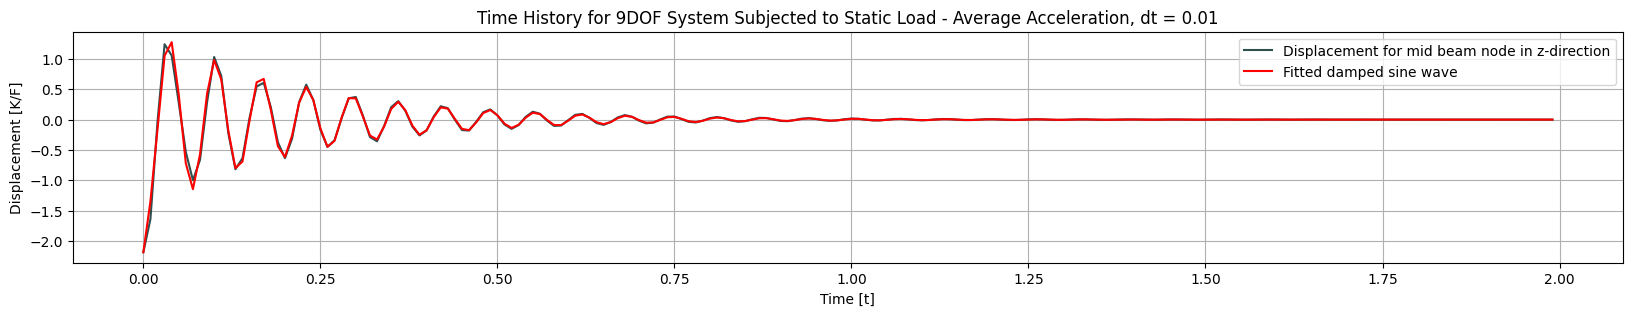

(2121, 32, 200)
(2121, 32, 8)


In [39]:
print(*dataY[2][4])

fitted = damped_sine_wave_2(time, *dataY[2][4])

title = 'Time History for 9DOF System Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, data[2][4], color='darkslategrey', label='Displacement for mid beam node in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
#plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
plt.xlabel('Time [t]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(data.shape)
print(dataY.shape)

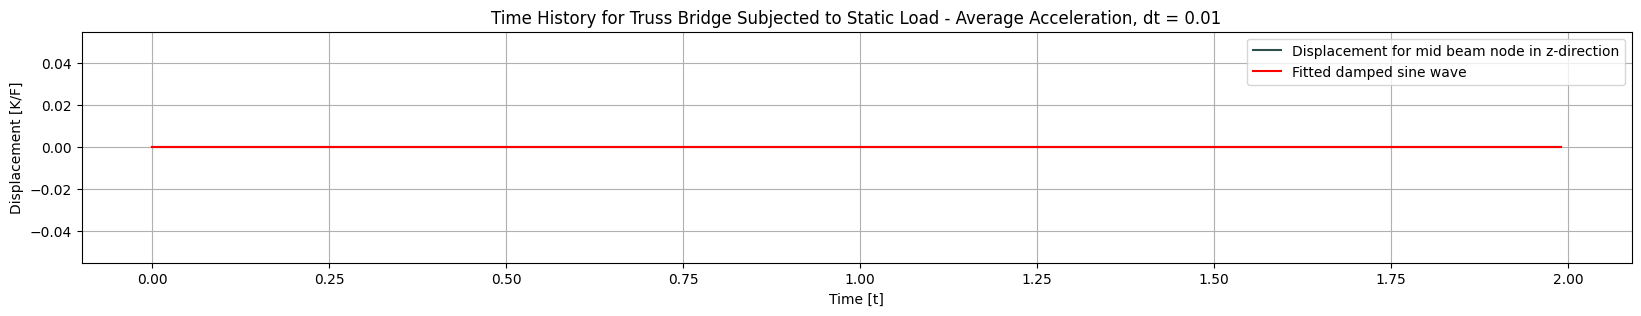

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


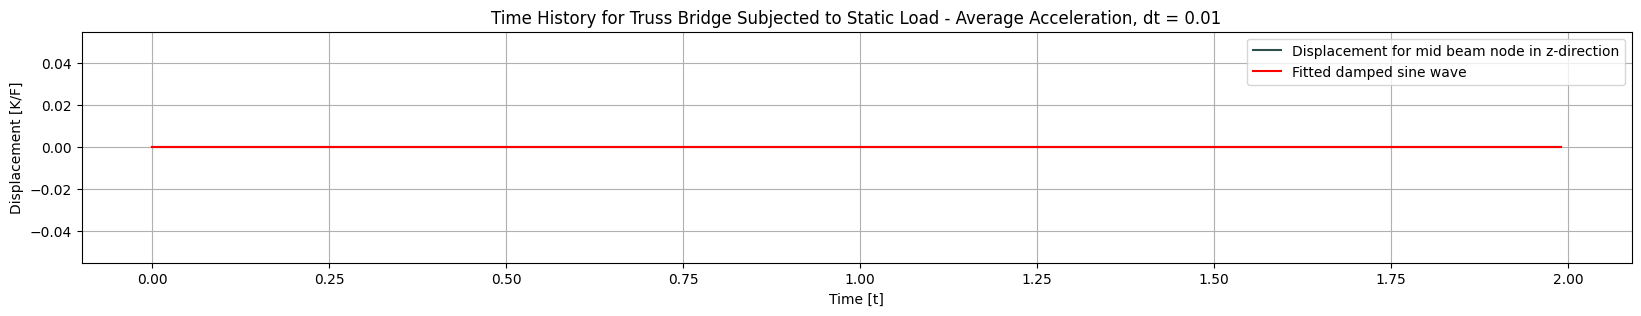

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


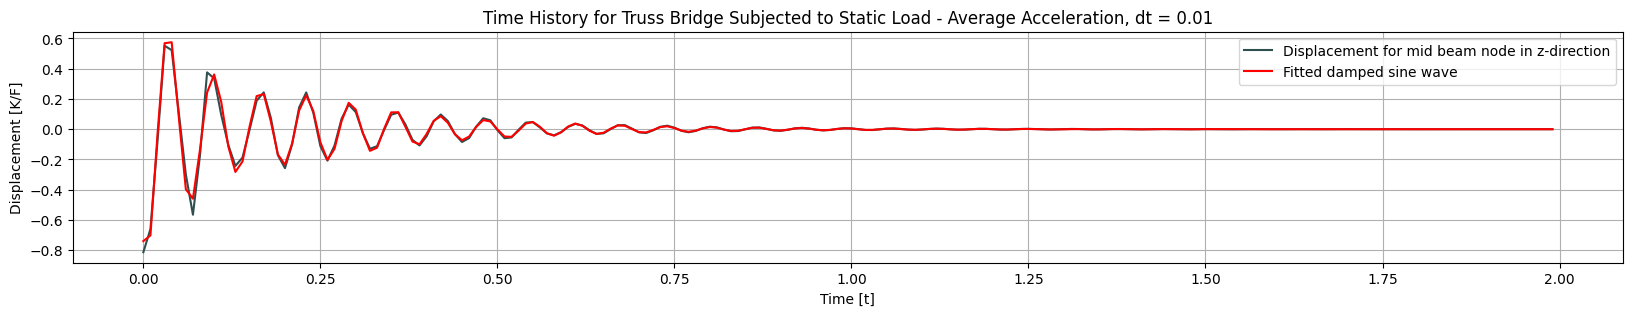

optimized parameters: 
0.6523529223069144 98.64451725972104 -2.153064197987072 4.721975674662356 0.20825813379330402 118.53493644921964 -1.9340147277439688 8.836590420704486


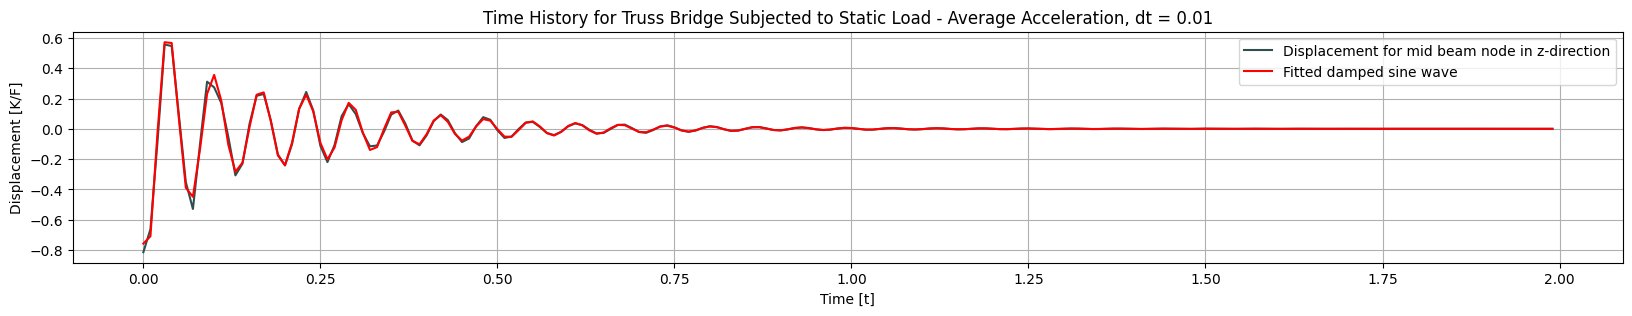

optimized parameters: 
0.6394803879332636 98.67039311233344 -2.163613274276265 4.616575071468975 0.24248509673684107 119.03092540332848 -1.9252250842802199 11.011578666890603


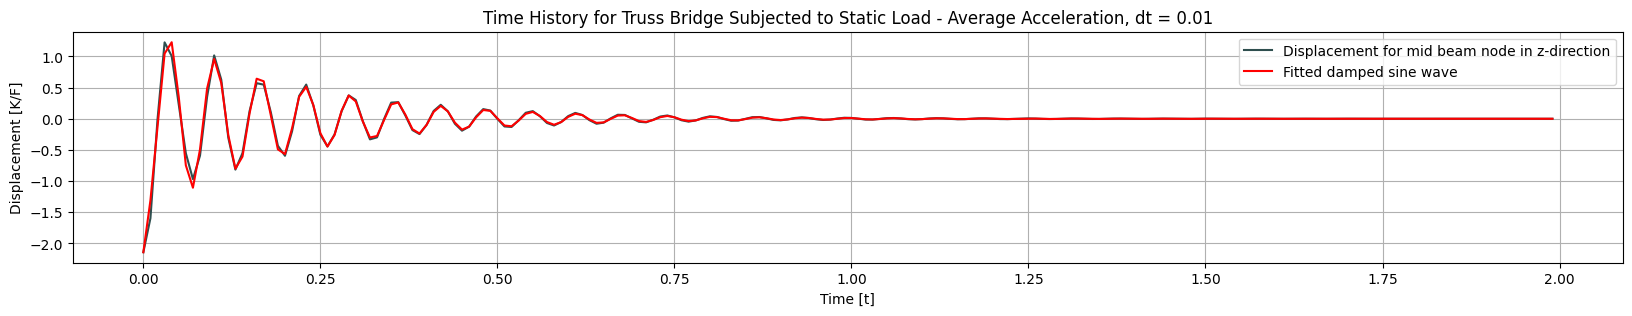

optimized parameters: 
1.5562293163165186 98.27521619360806 -2.0610154397399305 4.8019883973580555 9.637126426475191 -17198.014196667522 -0.0796730201554355 203796.7030088641


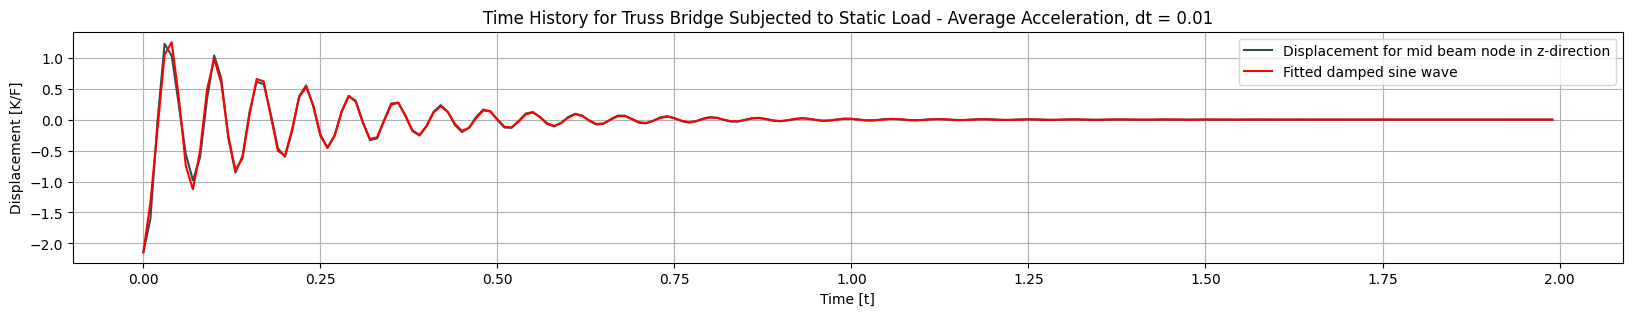

optimized parameters: 
1.5762814481568195 98.32002161305357 -2.072985839264475 4.729645523820145 8.780514455962653 -1849.385224801018 -0.08670383071355439 23600.71736157773


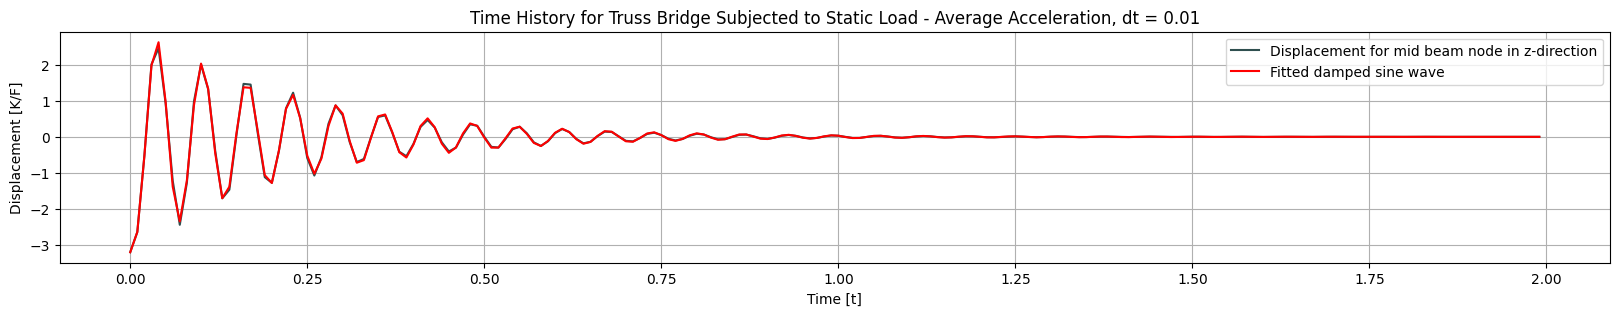

optimized parameters: 
3.1869301397535903 98.7203271046076 -2.1815604378428413 4.342948175302025 170.67607838780137 1.1027517943877936 -0.0035024249526300548 189.7313801930868


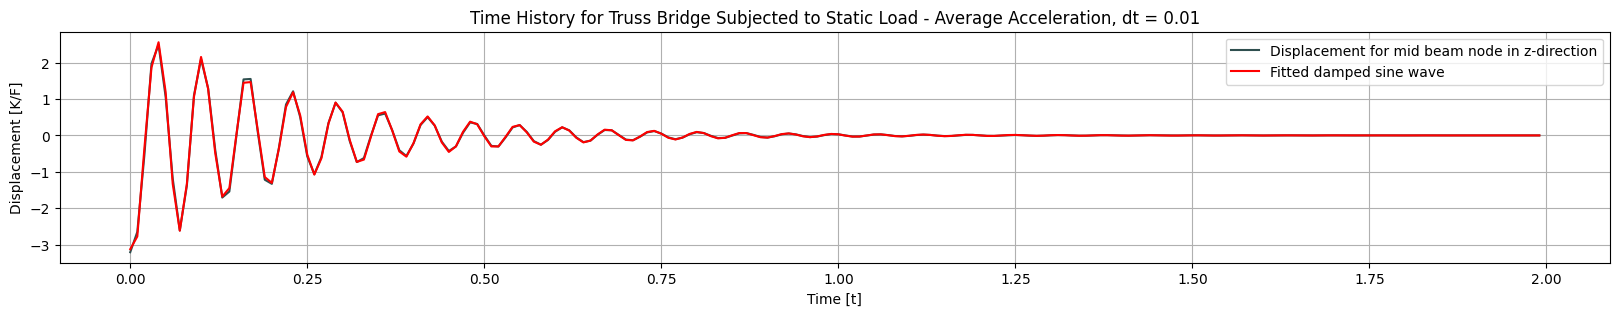

optimized parameters: 
3.3459224118891493 98.72040109321644 -2.180485803392696 4.414491560795072 0.42921488793153256 165.59407690499486 -1.113647708043834 11.752826808191694


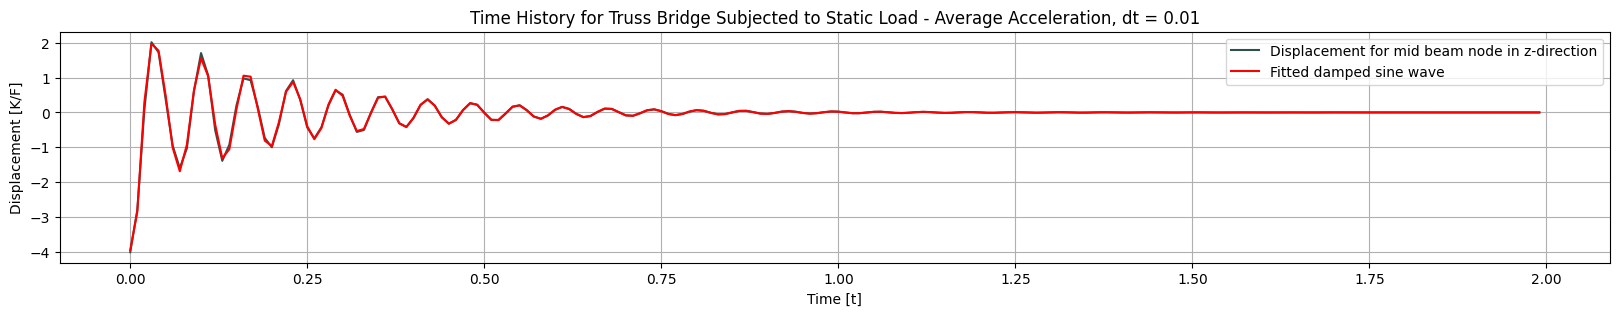

optimized parameters: 
2.480495867417484 98.70948812259438 -2.170898022587872 4.502537279372238 2.032287242765993 -143.28639667232423 -1.211745346847518 39.72641912221321


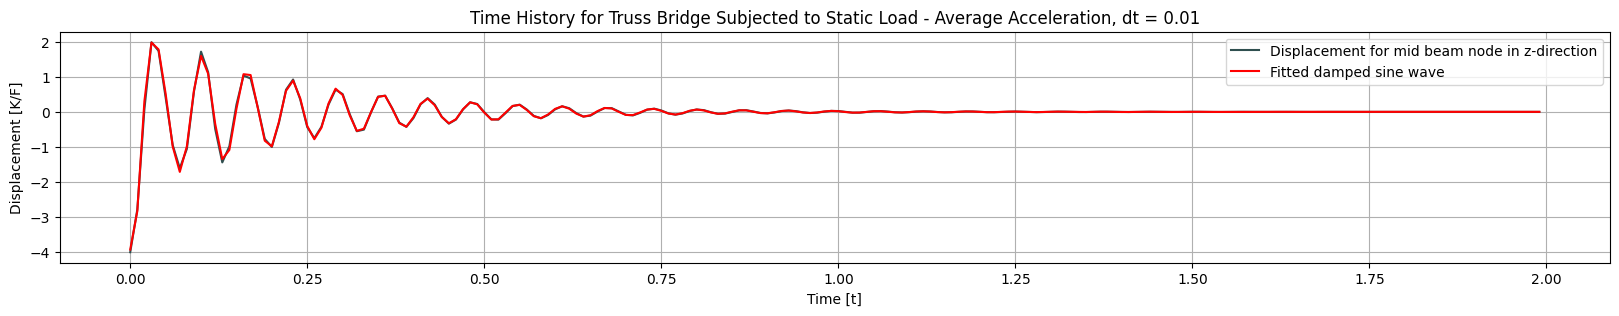

optimized parameters: 
2.561383485608288 98.78426096362223 -2.1890703011484116 4.552256829988736 1.9322526397298896 -143.80855139270116 -1.2775391087814432 35.98605827238856


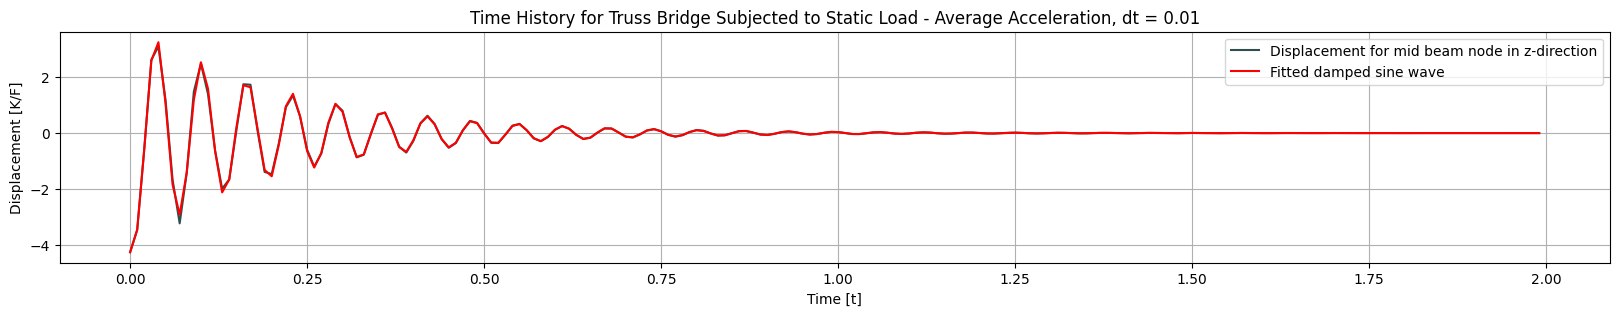

optimized parameters: 
4.014147101532016 98.55094432670401 -2.124684558024933 4.5384951302208245 69.67333723949226 314.1589046572735 -0.012099740240676662 349.4658619831386


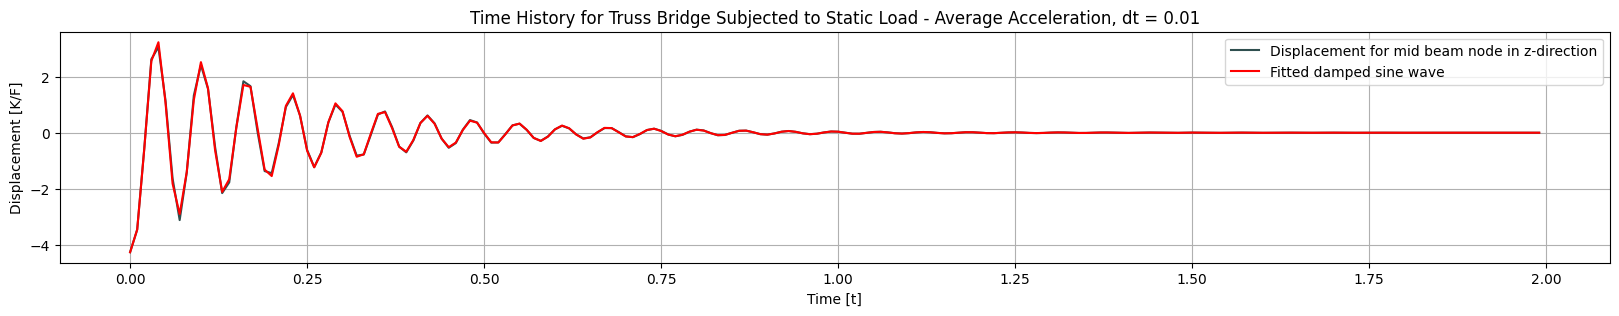

optimized parameters: 
3.973709750437033 98.56788656293213 -2.1309466220158555 4.493075760282064 176.66783045559734 302.442120072487 -0.005041443318307621 790.4030273783937


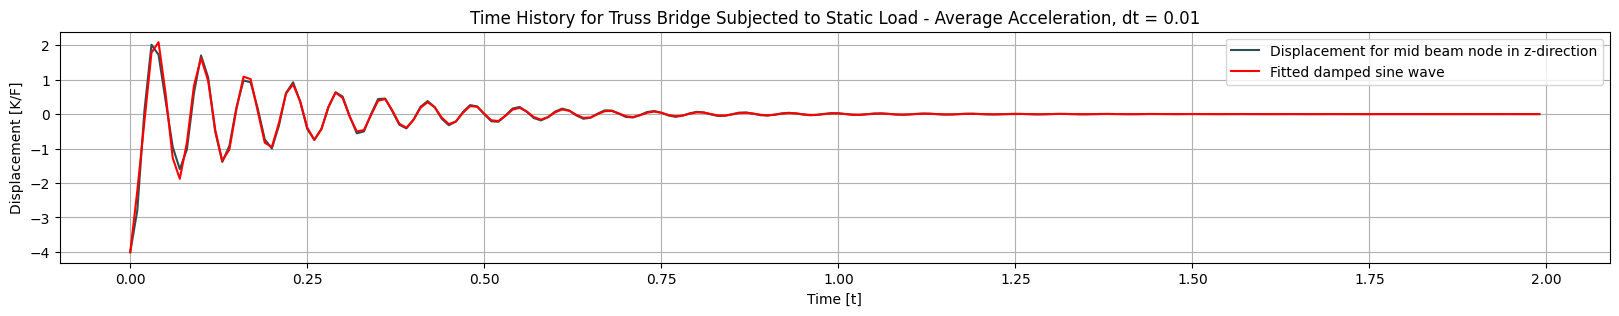

optimized parameters: 
2.6540175078546966 98.25979780339729 -2.0574336167224576 4.848716961067424 18.154046143201253 -15675.616201525627 -0.09180971280142365 178585.15354960164


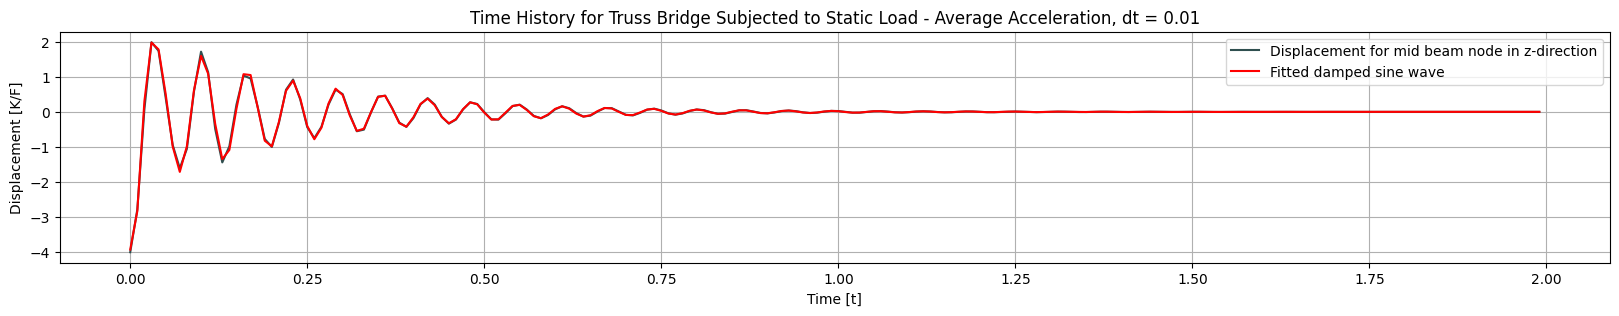

optimized parameters: 
2.561383575447767 98.78426118794985 -2.1890703546037935 4.5522569546494145 1.9322524544476178 -143.808536846305 -1.2775394387237657 35.98604805631367


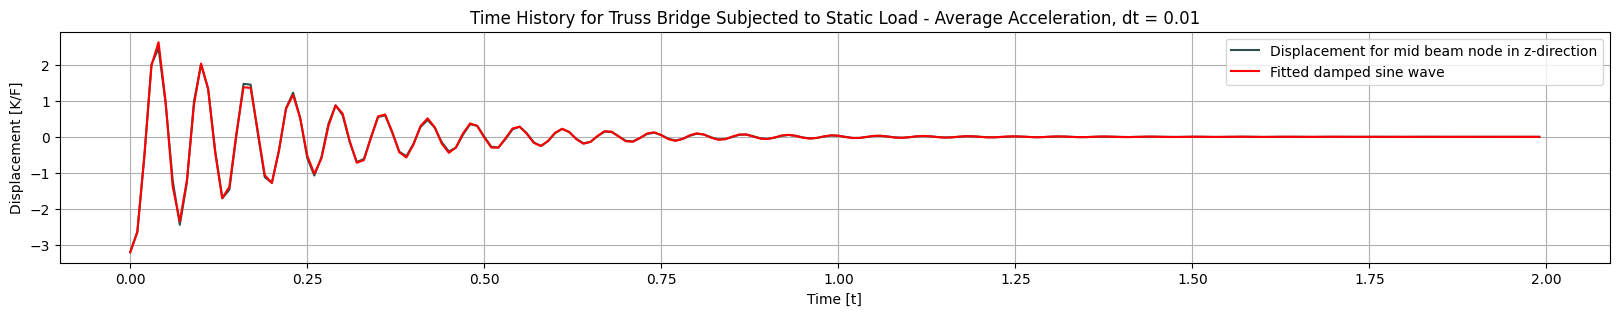

optimized parameters: 
3.186932119874907 98.72032358230203 -2.1815595146174793 4.342950726387007 132.55350872917109 1.4200021107917804 -0.004509733278318717 189.73884570623136


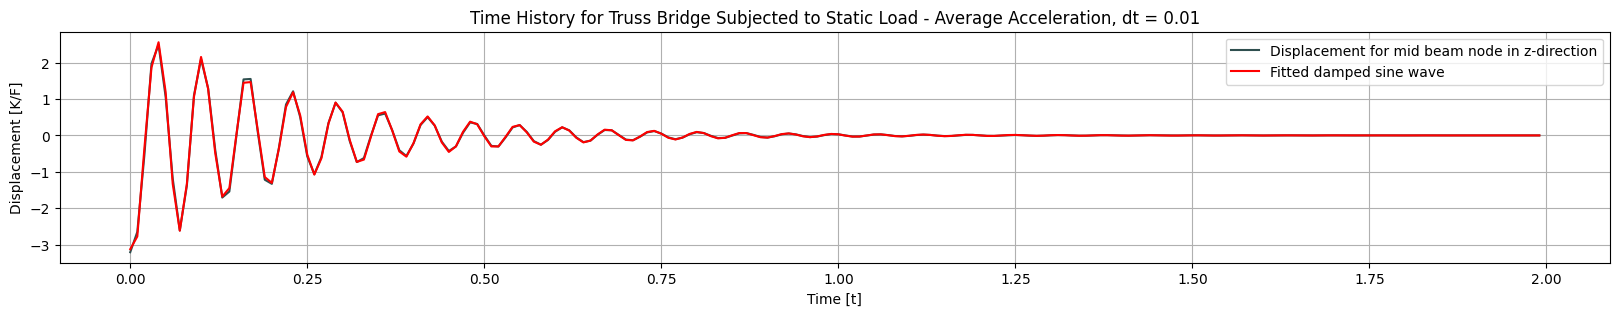

optimized parameters: 
3.3459224180205056 98.72040110449079 -2.1804858058634267 4.414491569442795 0.4292149055487981 165.59407621060072 -1.1136476566166158 11.75282758331869


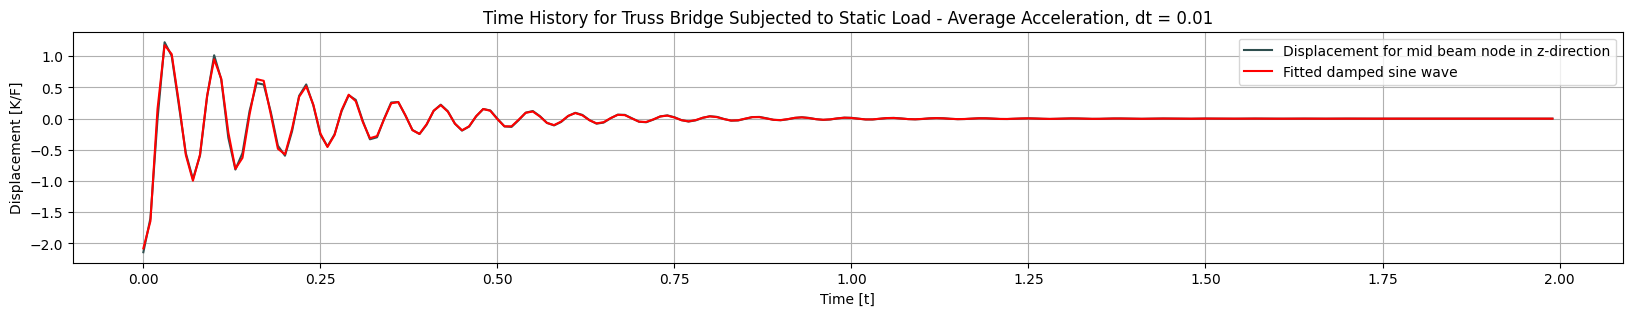

optimized parameters: 
1.5105380688865815 98.66990232044282 -2.1582123701511073 4.6194707686089975 0.8896044419784925 -147.25278337717694 -1.1764993040114478 29.663952006277924


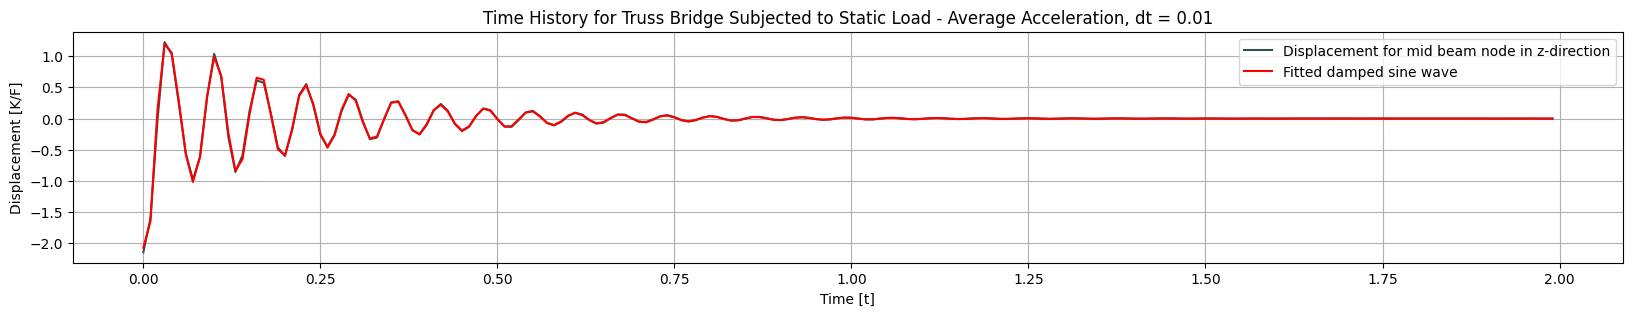

optimized parameters: 
1.5689501333367175 98.71169748656482 -2.1678974048400943 4.660623513801669 0.8161910199437026 -147.11065900085953 -1.243319862590386 25.680515896994123


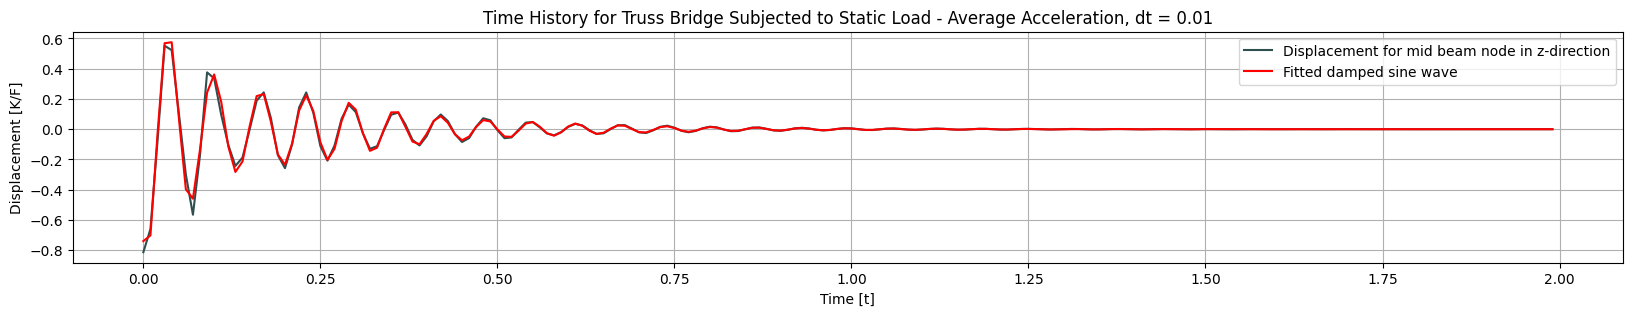

optimized parameters: 
0.6523528931442253 98.6445171842286 -2.153064189356915 4.7219755191263975 0.20825816784881043 118.53493730552948 -1.934014876582448 8.836592704019541


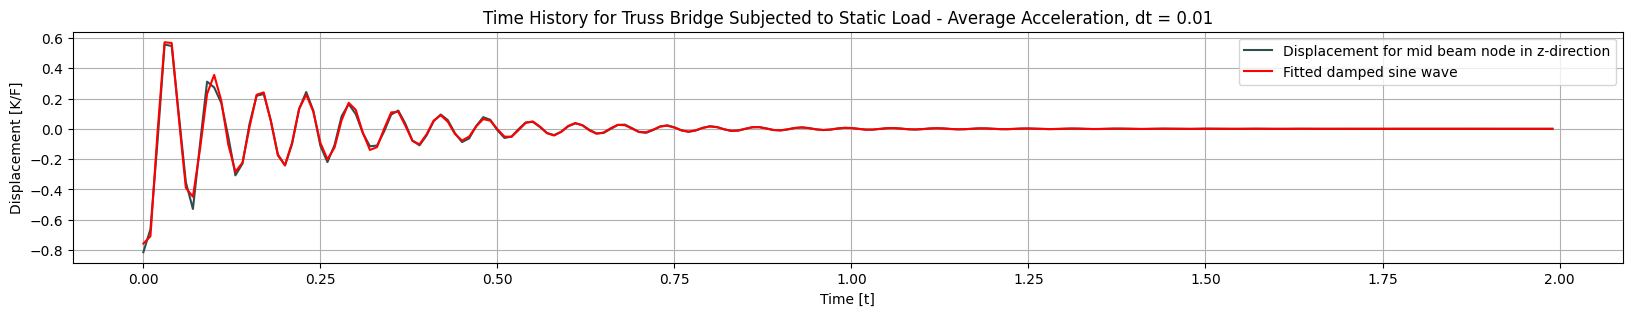

optimized parameters: 
0.639480197151757 98.67039226305249 -2.1636130991369393 4.61657417439929 0.24248529964182072 119.03093841813306 -1.9252264435070543 11.01159679350114


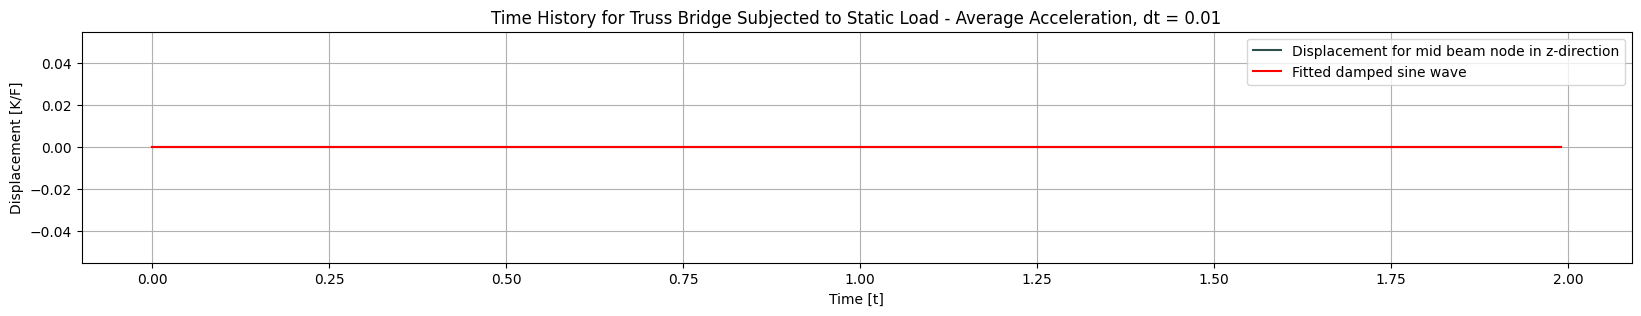

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


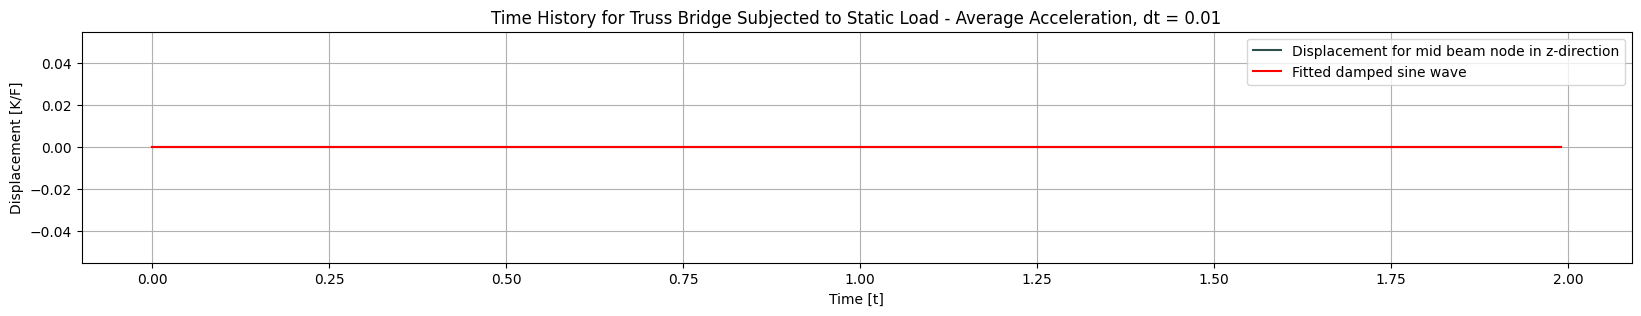

optimized parameters: 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


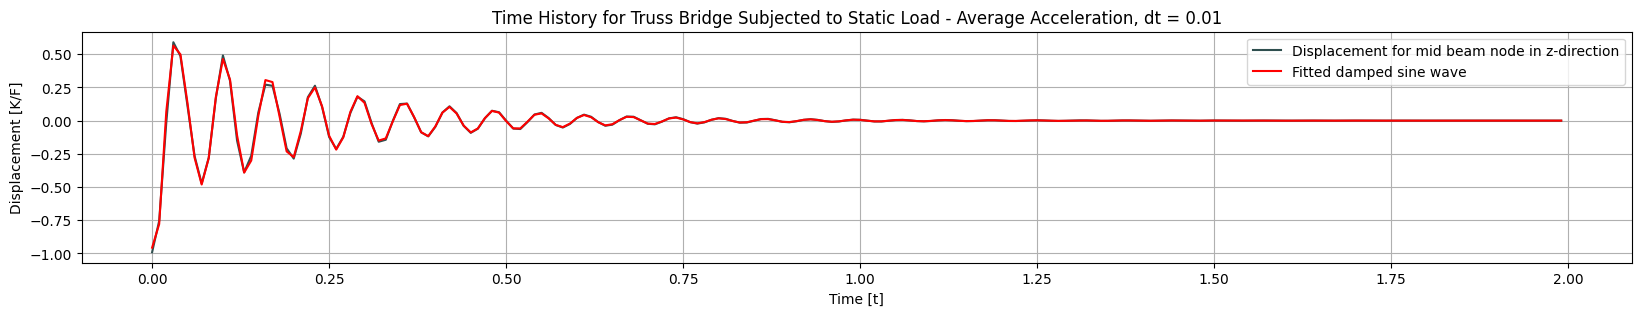

optimized parameters: 
0.7337065068134622 98.63624936059813 -2.148564945315679 4.662045576561131 0.37373460187144486 -148.87750938109735 -1.1565548752636532 26.750356131929088


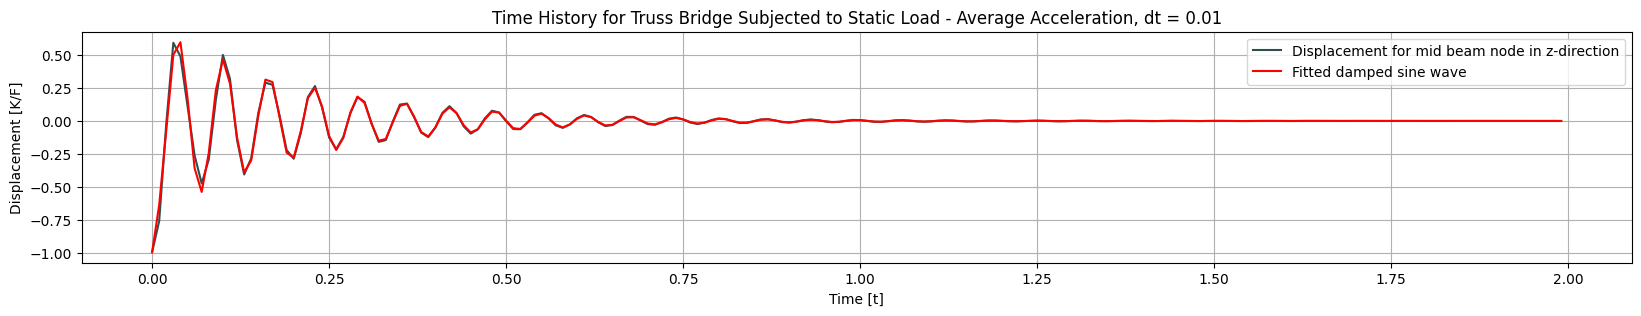

optimized parameters: 
0.7497810938161836 98.32139001719051 -2.073170840300488 4.722141711278786 3.9334284908503356 -1784.453720333178 -0.08519662091559688 23865.694213977433


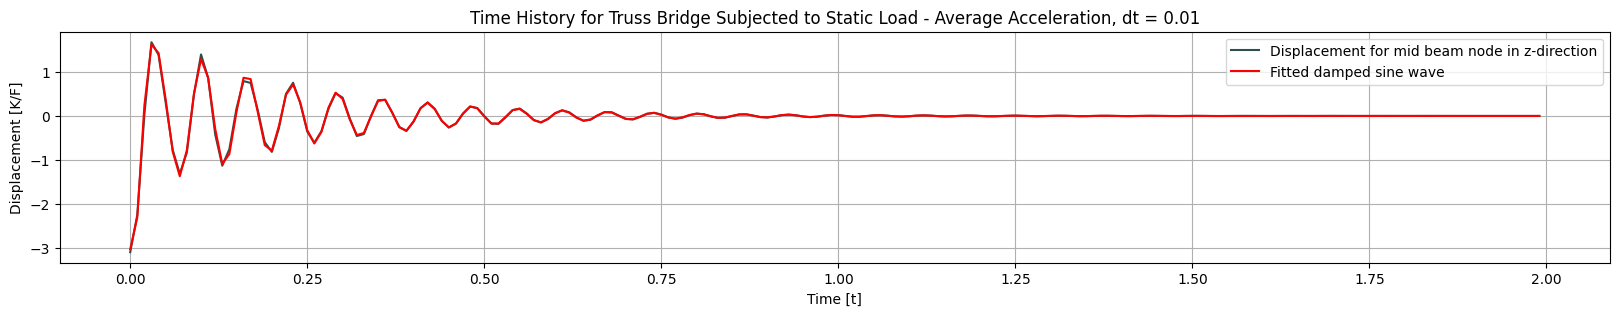

optimized parameters: 
2.057617306007189 98.69428453081993 -2.165384927972691 4.572260129034155 1.4242519328616343 -145.67165110436505 -1.1910576951746192 33.79136064744016


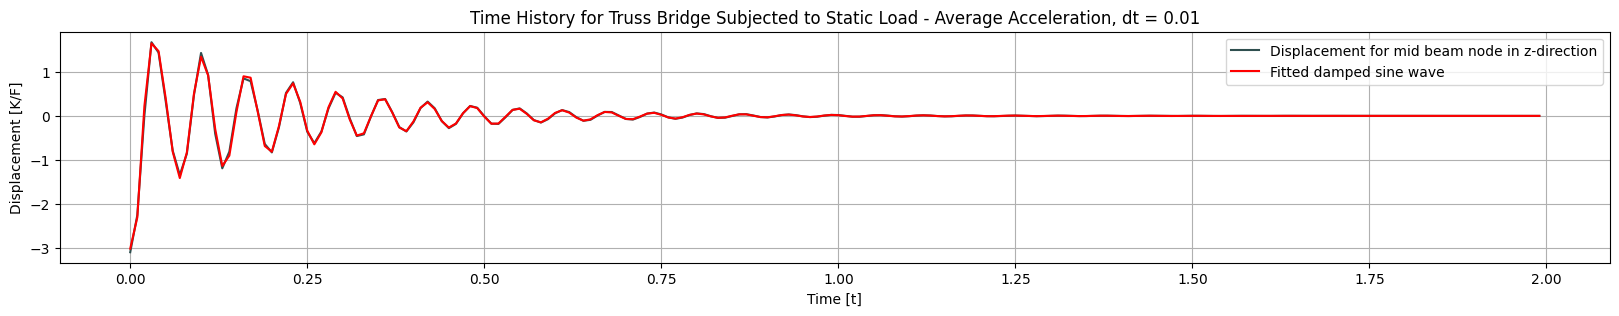

optimized parameters: 
2.1497891839009493 98.74448329527753 -2.1770848558809033 4.616794307484132 1.3126947089722094 -145.43913634018043 -1.2612671090055203 30.206760826248463


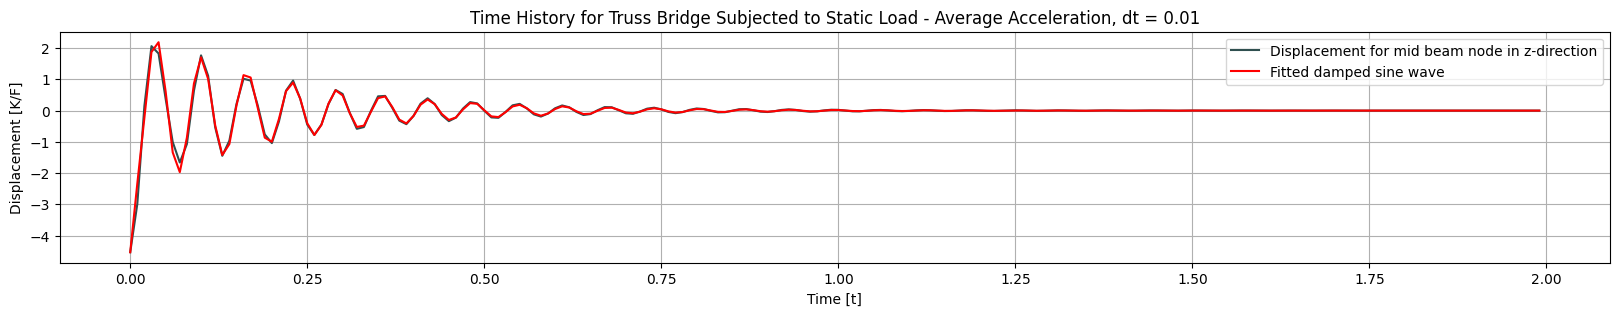

optimized parameters: 
2.7903360869279914 98.2505989266517 -2.055002519110093 4.892203387260896 18.67574115079452 -3182.012110929839 -0.11068522981164672 31652.72585116611


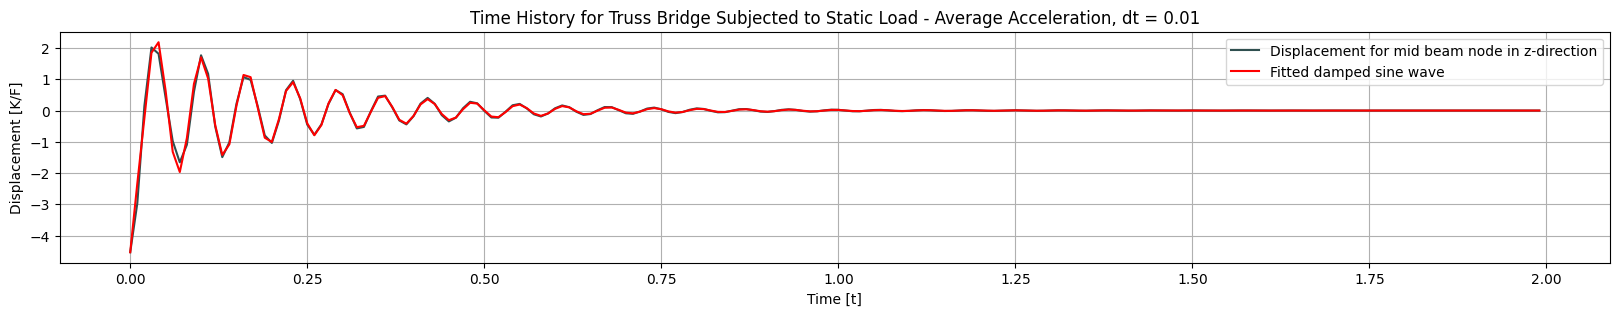

optimized parameters: 
2.7708186737833884 98.29426716026421 -2.0671610574011585 4.816161792737872 19.94639846502222 -20989.980643508305 -0.10538481140944826 216634.17660146352


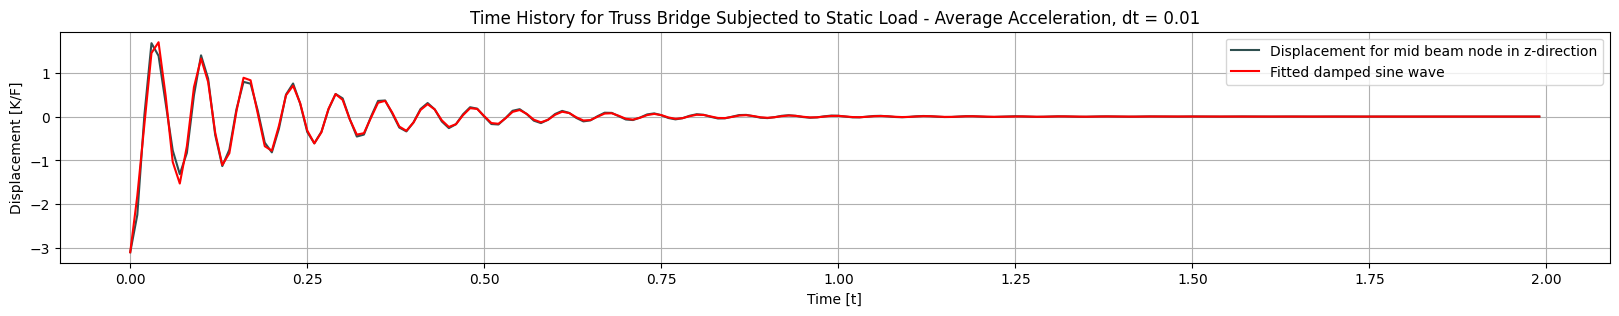

optimized parameters: 
2.155851323266204 98.26146360288415 -2.057701412789202 4.8309549158095795 15.182279735450456 -11582.935800880747 -0.07847549972329564 177886.48232482935


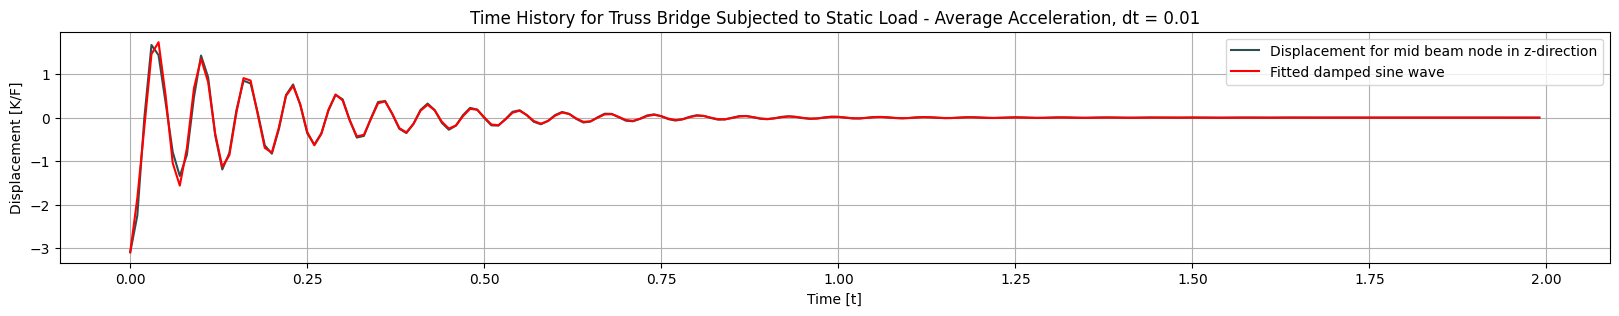

optimized parameters: 
2.1926142646695683 98.31150378214919 -2.0707278191602 4.75409181346956 12.112651398853451 -19152.377427393447 -0.09705403615641411 223474.66564673092


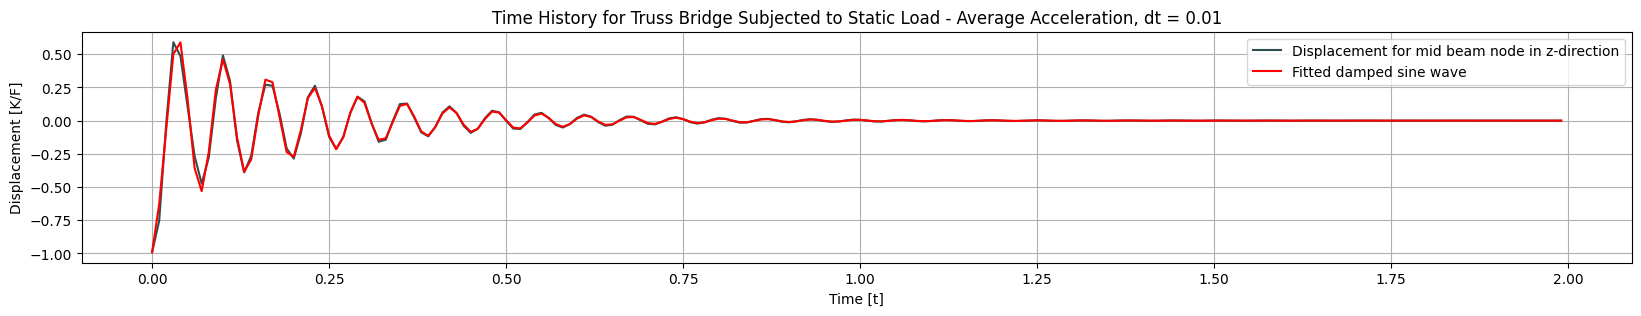

optimized parameters: 
0.7468621400405547 98.28719273704885 -2.063318771871892 4.78725351056369 3.974385479169459 -1532.5996607290479 -0.08385486109627155 21338.632592351772


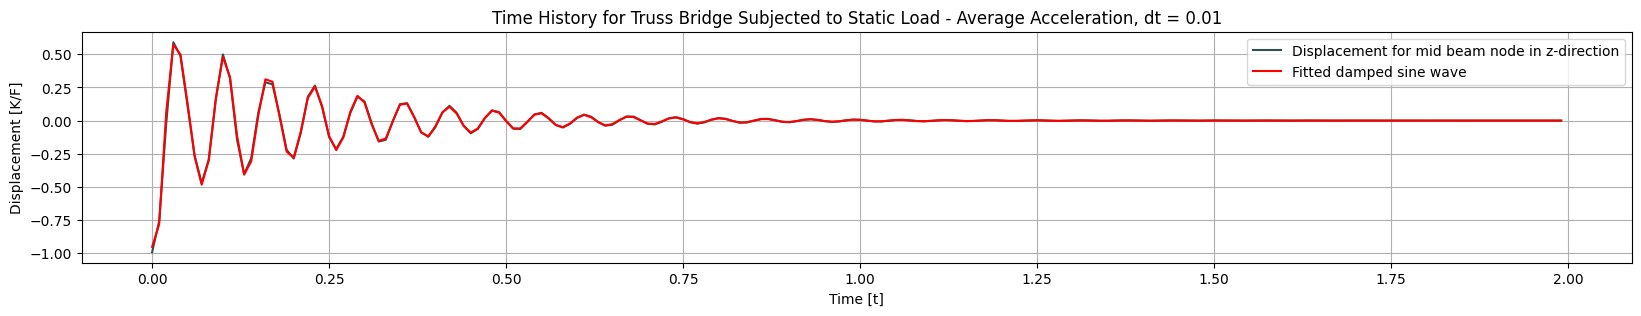

optimized parameters: 
0.7528363437652328 98.67388186606699 -2.1576627731321016 4.694691165756149 0.34753650947533155 -148.92181479208088 -1.2094257172249665 22.225931127240017


In [43]:
for i in range(data[0].shape[0]):
    fitted = damped_sine_wave_2(time, *dataY[0][i])

    title = 'Time History for Truss Bridge Subjected to Static Load - Average Acceleration, dt = '+str(dt)
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(3)
    plt.plot(time, data[0][i], color='darkslategrey', label='Displacement for mid beam node in z-direction')
    plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
    #plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
    plt.xlabel('Time [t]')
    plt.ylabel('Displacement [K/F]')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()
    print("optimized parameters: ")
    print(*dataY[0][i])

